# Analyse des modèles de chaleur spécifique : Estimation des températures de Debye et d'Einstein à partir de la densité d'états de phonons
Dans ce notebook, nous calculons les températures caractéristiques de Debye et d’Einstein qui minimisent l’erreur au sens des moindres carrés entre les modèles théoriques et les données expérimentales de chaleur spécifique dérivées de la densité d’états de phonons.
Nous comparons ensuite les courbes de chaleur spécifique issues du modèle réel et des deux modèles approchés, puis visualisons leurs densités d’états phononiques respectives.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.ext.matproj import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from scipy.optimize import minimize
from scipy.integrate import quad

In [2]:
mp_key = "71t7m37H7F5Jw2PfGOrlKxgH4ZbRQh3W"
mp_id = "mp-11739"

In [3]:
# Récupération des données de phonons
with MPRester(mp_key) as m:
    phonon_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    phonon_dos = m.get_phonon_dos_by_material_id(mp_id)
    structure = m.get_structure_by_material_id(mp_id)

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Structure des bandes phononiques et de leur densité d'états

In [4]:
fig_ph_dos = get_plot_dos(phonon_dos)
fig_ph_dos.show()

In [5]:
fig_ph_bs_and_dos = get_plot_bs_and_dos(phonon_bs, phonon_dos)
fig_ph_bs_and_dos.update_yaxes(rangemode="tozero")
fig_ph_bs_and_dos.show()

## Températures caractéristiques des modèles d'Einstein et de Debye

Dans l’étude des propriétés thermiques des solides, deux modèles fondamentaux permettent d’approximer le comportement des phonons : **le modèle d’Einstein** et **le modèle de Debye**. Ces modèles permettent de calculer la chaleur spécifique en fonction de la température, et introduisent chacun une température caractéristique : la température d’Einstein ($\theta_E$) et la température de Debye ($\theta_D$).

### Modèle d’Einstein

Le **modèle d’Einstein** repose sur l’hypothèse que tous les atomes du solide vibrent à la même fréquence $\omega_E$.

La **température d'Einstein** est définie par la relation :

$$
\theta_E = \frac{\hbar \omega_E}{k_B}
$$

La chaleur spécifique selon ce modèle est donnée par la formule suivante :

$$
C_V^{Einstein}(T) = 3Nk_B \left(\frac{\theta_E}{T}\right)^2 \frac{e^{\theta_E/T}}{\left(e^{\theta_E/T} - 1\right)^2}
$$

où :
- $N$ est le nombre d'atomes dans le système,
- $k_B$ est la constante de Boltzmann,
- $T$ est la température,
- $\theta_E$ est la **température d'Einstein**, proportionnelle à l’énergie de vibration des atomes.


###  Modèle de Debye

Le **modèle de Debye** considère une distribution continue des fréquences de vibration, jusqu'à une fréquence maximale $\omega_D$ telle que :  $$
\omega_D = v \cdot q_D
$$
où : 
- $v$ est la vitesse du son dans le matériau.
- $q_D$ est le vecteur d'onde.

La **température de Debye** est définie par :

$$
\theta_D = \frac{\hbar \omega_D}{k_B} = \frac{\hbar v q_D}{k_B}
$$

En effectuant le changement de variable :

$$
x = \frac{\hbar v q_D}{k_B T}
$$

la chaleur spécifique dans le modèle de Debye est exprimée par :

$$
C_V^{Debye}(T) = 9NR \left( \frac{T}{\theta_D} \right)^3 \int_0^{\theta_D/T} \frac{x^4 e^x}{(e^x - 1)^2} dx
$$

où :
- $\theta_D$ est la **température de Debye**, liée à la fréquence maximale de vibration des phonons dans le matériau.


Dans ce notebook, ces deux modèles sont ajustés aux données expérimentales obtenues à partir de la densité d’états de phonons. On cherche les températures $\theta_E$ et $\theta_D$ qui minimisent l’erreur quadratique entre les modèles et la courbe réelle de chaleur spécifique.


In [6]:
# Extraire les fréquences et la densité d'états
frequencies = phonon_dos.frequencies
dos = phonon_dos.densities

In [7]:
# Constantes physiques
k_B = 1.380649e-23  # Constante de Boltzmann en J/K
h = 6.62607015e-34  # Constante de Planck en J·s
N = len(structure)  # Nombre d'atomes
R = 8.314  # Constante des gaz parfaits en J/(mol·K)

In [8]:
# Températures pour l'analyse
True_T = np.arange(5, 1000, 5)  # Températures en Kelvin

# Fonction pour calculer la chaleur spécifique à partir de la méthode phonon_dos.cv
Cv = np.array([phonon_dos.cv(T) / (3 * N * R) for T in True_T])

In [9]:
# Modèle d’Einstein
def Einstein(T, theta_E):
    exp = np.exp(theta_E / T)
    return (theta_E / T)**2 * (exp / (exp - 1)**2)

def error_Einstein(theta_E):
    Cv_E = Einstein(True_T, theta_E)
    return np.sum((Cv - Cv_E)**2)

theta_E_opt = minimize(error_Einstein, 200).x[0]
print(f"Température d’Einstein optimale : {theta_E_opt:.2f} K")

Température d’Einstein optimale : 131.13 K


In [10]:
# Modèle de Debye
def integrand(x):
    exp = np.exp(x)
    return (x**4 * exp) / ((exp - 1)**2)

def debye_model(T, theta_D):
    integral, _ = quad(integrand, 0, theta_D / T)
    return 3 * (T / theta_D)**3 * integral

# Fonction d'erreur pour le modèle de Debye
def error_Debye(theta_D):
    return np.sum([(debye_model(T, theta_D) - Cv[i])**2 for i, T in enumerate(True_T)])

# Optimisation pour trouver theta_D optimal pour Debye
theta_D_opt = minimize(error_Debye, 200).x[0]
print(f"Température de Debye optimale : {theta_D_opt:.2f} K")

Température de Debye optimale : 177.25 K


## Graphes des températures caractéristiques

In [11]:
# Axes réduits
T_over_theta_E = True_T / theta_E_opt
T_over_theta_D = True_T / theta_D_opt

# Chaleur spécifique modélisée
Cv_Einstein = Einstein(True_T, theta_E_opt)
Cv_Debye = np.array([debye_model(T, theta_D_opt) for T in True_T])

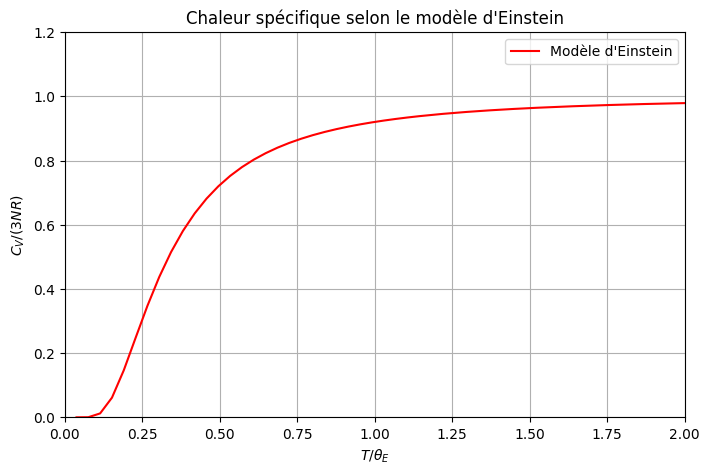

In [12]:
# === Graphe 1 : Einstein ===
plt.figure(figsize=(8, 5))
plt.plot(T_over_theta_E, Cv_Einstein, label="Modèle d'Einstein", color='red')


plt.xlabel(r"$T / \theta_E$")
plt.ylabel(r"$C_V / (3NR)$")
plt.title("Chaleur spécifique selon le modèle d'Einstein")
plt.legend()
plt.grid(True)
plt.xlim(0, 2)
plt.ylim(0, 1.2)
plt.show()

### Comportement du modèle d'Einstein

À **hautes températures** T >> $\Theta_E$, la chaleur spécifique suit la formule :
$$
C_V \rightarrow 3 \cdot N \cdot R
$$

À **basses températures** T << $\Theta_E$, la chaleur spécifique suit l'expression :
$$
C_V \propto e^{-\Theta_E/T}
$$


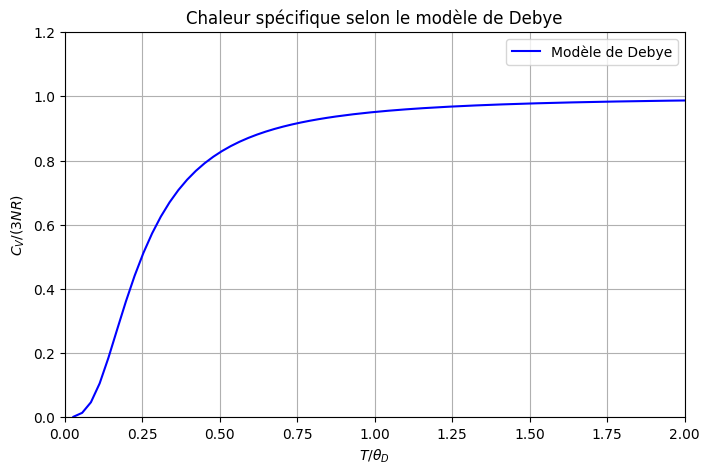

In [13]:
# === Graphe 2 : Debye ===
plt.figure(figsize=(8, 5))
plt.plot(T_over_theta_D, Cv_Debye, label="Modèle de Debye",color='blue')

plt.xlabel(r"$T / \theta_D$")
plt.ylabel(r"$C_V / (3NR)$")
plt.title("Chaleur spécifique selon le modèle de Debye")
plt.legend()
plt.grid(True)
plt.xlim(0, 2)
plt.ylim(0, 1.2)
plt.show()

### Comportement du modèle de Debye

À **hautes températures** T >> $\Theta_D$, la chaleur spécifique suit la formule :
$$
C_V \rightarrow 3 \cdot N \cdot R
$$

À **basses températures** T << $\Theta_D$, la chaleur spécifique suit l'expression :
$$
C_V \propto T^3
$$


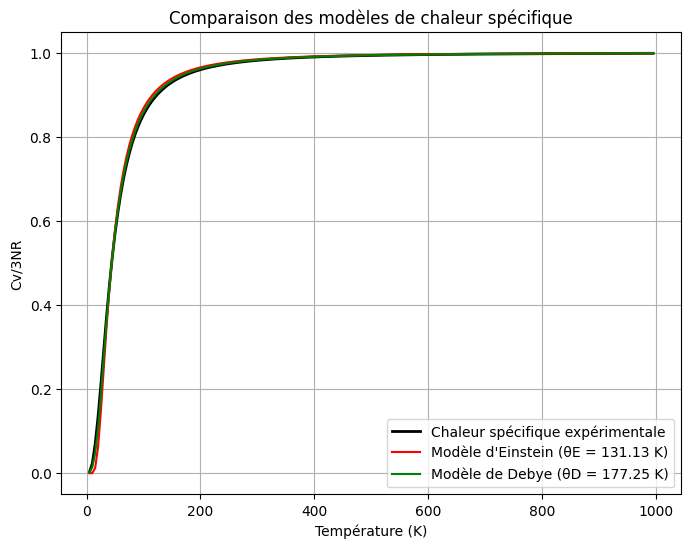

In [14]:
# Chaleur spécifique modèle de Debye (vectorisée)
Cv_D = np.array([debye_model(T, theta_D_opt) for T in True_T])

# Chaleur spécifique modèle d'Einstein
Cv_E = Einstein(True_T, theta_E_opt)

# Affichage des trois courbes de chaleur spécifique
plt.figure(figsize=(8, 6))
plt.plot(True_T, Cv, label="Chaleur spécifique expérimentale", color='black', linewidth=2)
plt.plot(True_T, Cv_E, label=f"Modèle d'Einstein (θE = {theta_E_opt:.2f} K)", color='red')
plt.plot(True_T, Cv_D, label=f"Modèle de Debye (θD = {theta_D_opt:.2f} K)", color='green')

# Ajouter des labels et un titre
plt.xlabel("Température (K)")
plt.ylabel("Cv/3NR")
plt.title("Comparaison des modèles de chaleur spécifique")
plt.legend()
plt.grid(True)
plt.show()


## Comparaison des densités d'états des phonons

La densité d'états des phonons représente les différents modes de vibration accessibles pour une fréquence donnée. 
La densité de modes normaux est normalisée de telle sorte que :

$$
\int_0^{\infty} g(\omega) \, d\omega = 3 N_{\text{at}}
$$
Cette relation montre que chaque atome peut vibrer selon 3 directions. 

Dans le **modèle d'Einstein**, la densité d'états est un pic delta en $\omega = \omega_E$ :

$$
g(\omega) = 3 N_{\text{at}} \delta(\omega - \omega_E)
$$

Dans le **modèle de Debye**, la densité d'états est une fonction parabolique de la fréquence $\omega$ pour $\omega < \omega_D$, et est nulle pour $\omega > \omega_D$ :

$$
g_D(\omega) = 
\begin{cases} 
\frac{3 N_{\text{at}} \Omega\omega^2}{2 \pi^2 v^3} & \text{pour} \, \omega < \omega_D \\
0 & \text{pour} \, \omega > \omega_D
\end{cases}
$$

Avec $\omega = v q$, $\omega_D = v q_D$, où $v$ est la vitesse du son et $q_D$ est le vecteur d'onde de Debye correspondant à la fréquence de Debye $\omega_D$.


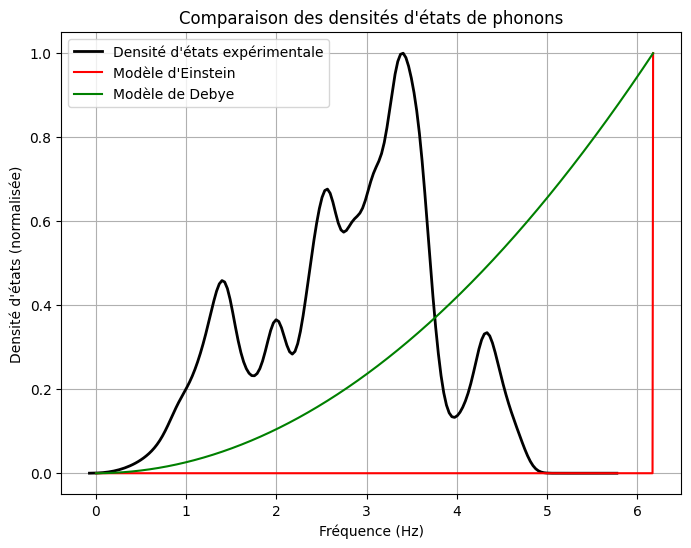

In [15]:
# Génération des fréquences pour les modèles théoriques
freqs_model = np.linspace(0, theta_D_freq * 1.5, 1000)

# Densité d'états du modèle d'Einstein (delta centrée sur theta_E)
dos_einstein = np.zeros_like(freqs_model)
theta_E_freq = theta_E_opt * k_B / h  # Conversion de θE (K) en Hz
index_E = np.abs(freqs_model - theta_E_freq).argmin()
dos_einstein[index_E] = 1  # pic de Dirac simulé

# Densité d'états du modèle de Debye (forme ∝ ω² pour ω < ω_D)
omega_D = theta_D_opt * k_B / h  # fréquence de coupure de Debye
dos_debye = np.where(freqs_model <= omega_D, freqs_model**2, 0)
# Normalisation pour comparaison visuelle
dos_debye = dos_debye / np.max(dos_debye)

# Densité d'états expérimentale (normalisée pour affichage)
dos_exp = dos / np.max(dos)

# Tracé des densités d'états
plt.figure(figsize=(8, 6))
plt.plot(frequencies, dos_exp, label="Densité d'états expérimentale", color='black', linewidth=2)
plt.plot(freqs_model, dos_einstein, label="Modèle d'Einstein", color='red')
plt.plot(freqs_model, dos_debye, label="Modèle de Debye", color='green')

plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité d'états (normalisée)")
plt.title("Comparaison des densités d'états de phonons")
plt.legend()
plt.grid(True)
plt.show()
